In [2]:
import sys
sys.path.append("../")  # path contains python_file.py

In [3]:
import iris
import numpy as np
import scipy.stats

In [4]:
%load_ext autoreload
%autoreload 2

# Testing data ISIMIP

In [5]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def day(x):
    return x.day

def month(x):
    return x.month

def year(x):
    return x.year

day = np.vectorize(day)
month = np.vectorize(month)
year = np.vectorize(year)


def read_in_and_preprocess_isimip_testing_data_with_dates(variable, grid_point = [0,0]):
    
    obs = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm_hist = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    cm_future = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "obs": get_dates(obs),
        "cm_hist": get_dates(cm_hist),
        "cm_future": get_dates(cm_future)
    }
    
    obs = np.array(obs.data)
    cm_hist = np.array(cm_hist.data)
    cm_future = np.array(cm_future.data)

    
    obs = np.moveaxis(obs, -1, 0)
    cm_hist = np.moveaxis(cm_hist, -1, 0)
    cm_future = np.moveaxis(cm_future, -1, 0)

    obs = obs[:,  grid_point[0], grid_point[1]]
    cm_hist = cm_hist[:,  grid_point[0], grid_point[1]]
    cm_future = cm_future[:,  grid_point[0], grid_point[1]]
    
    return obs, cm_hist, cm_future, dates

# Comparison ISIMIP and PACKAGE_NAME

In [6]:
from PACKAGE_NAME.debias import ISIMIP
import PACKAGE_NAME.code_isimip.utility_functions as uf
from PACKAGE_NAME.code_isimip.bias_adjustment import adjust_bias_one_month, map_quantiles_parametric_trend_preserving

## Step 5: pseudo future observations

In [7]:
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("tas")

debiaser = ISIMIP.from_variable(variable="tas")
debiaser

ISIMIP(distribution=<scipy.stats._continuous_distns.norm_gen object at 0x7fda2e016d00>, trend_preservation_method='additive', detrending=True, reasonable_physical_range=[0, 400], variable='tas', lower_bound=-inf, lower_threshold=-inf, upper_bound=inf, upper_threshold=inf, trend_removal_with_significance_test=True, trend_transfer_only_for_values_within_threshold=True, event_likelihood_adjustment=False, ecdf_method='linear_interpolation', iecdf_method='linear', running_window_mode=True, running_window_length=31, running_window_step_length=1)

In [85]:
for chosen_month in range(1, 13):
    obs_month = obs[month(dates["obs"]) == chosen_month]
    cm_hist_month = cm_hist[month(dates["cm_hist"]) == chosen_month]
    cm_future_month = cm_future[month(dates["cm_future"]) == chosen_month]

    future_observations = debiaser.step5(obs_month, cm_hist_month, cm_future_month)
    future_observations_isimip = uf.map_quantiles_non_parametric_trend_preserving(
        x_obs_hist = obs_month, x_sim_hist = cm_hist_month, x_sim_fut = cm_future_month, 
        trend_preservation = debiaser.trend_preservation_method, 
        n_quantiles = min(obs_month.size, cm_hist_month.size, cm_future_month.size)-1,
        max_change_factor = 100., max_adjustment_factor = 9.,
        adjust_obs = True, 
        lower_bound = None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound,
        upper_bound = None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound
    )

    pct = np.sum(np.isclose(future_observations, future_observations_isimip))/future_observations_isimip.size
    max_deviation = np.max(np.abs(future_observations-future_observations_isimip))
    print("Month: %s, Percentage agreement: %s, Max deviation: %s"%(chosen_month, pct, max_deviation))


Month: 1, Percentage agreement: 1.0, Max deviation: 9.663381206337363e-13
Month: 2, Percentage agreement: 0.5398230088495575, Max deviation: 0.14852493135487066
Month: 3, Percentage agreement: 1.0, Max deviation: 2.7853275241795927e-12
Month: 4, Percentage agreement: 1.0, Max deviation: 5.115907697472721e-13
Month: 5, Percentage agreement: 1.0, Max deviation: 1.2505552149377763e-12
Month: 6, Percentage agreement: 1.0, Max deviation: 2.8421709430404007e-13
Month: 7, Percentage agreement: 1.0, Max deviation: 1.1368683772161603e-13
Month: 8, Percentage agreement: 1.0, Max deviation: 5.684341886080802e-14
Month: 9, Percentage agreement: 1.0, Max deviation: 1.0231815394945443e-12
Month: 10, Percentage agreement: 1.0, Max deviation: 5.684341886080802e-14
Month: 11, Percentage agreement: 1.0, Max deviation: 2.2737367544323206e-13
Month: 12, Percentage agreement: 1.0, Max deviation: 5.684341886080802e-14


In [88]:
chosen_month = 2
obs_month = obs[month(dates["obs"]) == chosen_month]
cm_hist_month = cm_hist[month(dates["cm_hist"]) == chosen_month]
cm_future_month = cm_future[month(dates["cm_future"]) == chosen_month]

future_observations = debiaser.step5(obs_month, cm_hist_month, cm_future_month)
future_observations_isimip = uf.map_quantiles_non_parametric_trend_preserving(
    x_obs_hist = obs_month, x_sim_hist = cm_hist_month, x_sim_fut = cm_future_month, 
    trend_preservation = debiaser.trend_preservation_method, 
    n_quantiles = min(obs_month.size, cm_hist_month.size, cm_future_month.size)-1,
    max_change_factor = 100., max_adjustment_factor = 9.,
    adjust_obs = True, 
    lower_bound = None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound,
    upper_bound = None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound
)

pct = np.sum(np.isclose(future_observations, future_observations_isimip))/future_observations_isimip.size
max_deviation = np.max(np.abs(future_observations-future_observations_isimip))
print("Month: %s, Percentage agreement: %s, Max deviation: %s"%(chosen_month, pct, max_deviation))


Month: 2, Percentage agreement: 0.5398230088495575, Max deviation: 0.14852493135487066


In [139]:
import PACKAGE_NAME.code_isimip.utility_functions as uf

x_obs_hist = obs_month
x_sim_hist = cm_hist_month
x_sim_fut = cm_future_month
n_quantiles = min(obs_month.size, cm_hist_month.size, cm_future_month.size)-1


p_zeroone = np.linspace(0.0, 1.0, n_quantiles)

# compute quantiles of input data
q_obs_hist = uf.percentile1d(x_obs_hist, p_zeroone)
q_sim_hist = uf.percentile1d(x_sim_hist, p_zeroone)
q_sim_fut = uf.percentile1d(x_sim_fut, p_zeroone)

# compute quantiles needed for quantile delta mapping
p = np.interp(x_obs_hist, q_obs_hist, p_zeroone)
p_saving = np.interp(x_obs_hist, q_obs_hist, p_zeroone)
F_sim_fut_inv = np.interp(p, p_zeroone, q_sim_fut)
F_sim_hist_inv = np.interp(p, p_zeroone, q_sim_hist)
F_obs_hist_inv = np.interp(p, p_zeroone, q_obs_hist)

# do augmented quantile delta mapping
y = F_obs_hist_inv + F_sim_fut_inv - F_sim_hist_inv

np.max(np.abs(y - future_observations))


0.19445096785739224

In [153]:
from PACKAGE_NAME.utils import iecdf, ecdf, threshold_cdf_vals

def ecdf(x,y, n = n_quantiles):
    p_grid = np.linspace(0.0, 1.0, n)
    q_vals_for_p_grid = np.quantile(x, p_grid)
    return np.interp(y, q_vals_for_p_grid, p_grid)


p = ecdf(obs_month, obs_month)

# Compute q-vals: q = IECDF(p)
q_obs_hist = obs_month  # TODO: = iecdf(obs_hist, p, method=self.iecdf_method), appears in eq. 7

q_cm_future = iecdf(cm_future_month, p, method=debiaser.iecdf_method)
q_cm_hist = iecdf(cm_hist_month, p, method=debiaser.iecdf_method)

delta_add = q_cm_future - q_cm_hist
x = obs_month + delta_add

In [154]:
np.max(np.abs(x-y))

0.027361487508017035

In [155]:
np.max(np.abs(p-p_saving))

9.747758156208874e-14

In [149]:
obs_month.size - n_quantiles

2

In [ ]:
# Problem lies again in n_quantiles

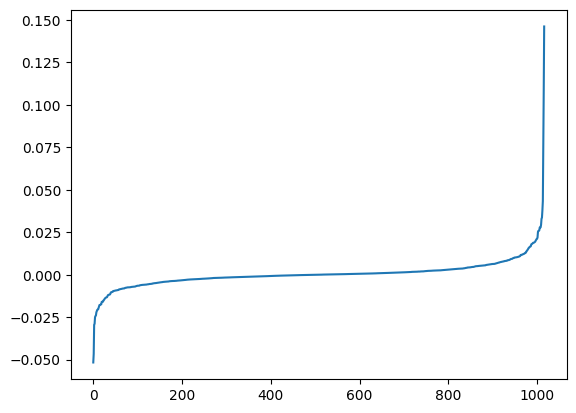

In [112]:
import matplotlib.pyplot as pl
plt.plot(list(range(q_cm_hist.size)), np.sort(q_cm_hist - F_sim_hist_inv))
plt.show()

## Step 6: Quantile transfer

First: work with future observations from ISIMIP in step5 and run them through step6.

In [71]:
from PACKAGE_NAME.code_isimip.bias_adjustment import adjust_bias_one_month, map_quantiles_parametric_trend_preserving
import PACKAGE_NAME.code_isimip.utility_functions as uf

obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("tas")
debiaser = ISIMIP.from_variable(variable="tas")
#debiaser.event_likelihood_adjustment = False

for chosen_month in range(1,13):
    obs_month = obs[month(dates["obs"]) == chosen_month]
    cm_hist_month = cm_hist[month(dates["cm_hist"]) == chosen_month]
    cm_future_month = cm_future[month(dates["cm_future"]) == chosen_month]

    future_observations_isimip = uf.map_quantiles_non_parametric_trend_preserving(
        x_obs_hist = obs_month, x_sim_hist = cm_hist_month, x_sim_fut = cm_future_month, 
        trend_preservation = debiaser.trend_preservation_method, 
        n_quantiles = min(obs_month.size, cm_hist_month.size, cm_future_month.size)-1,
        max_change_factor = 100., max_adjustment_factor = 9.,
        adjust_obs = True, 
        lower_bound = None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound,
        upper_bound = None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound
    )

    step6_using_isimip_obs_future = debiaser.step6(obs_month, future_observations_isimip, cm_hist_month, cm_future_month)
    isimip_mapping = map_quantiles_parametric_trend_preserving(
        x_obs_hist = obs_month, x_sim_hist = cm_hist_month, x_sim_fut = cm_future_month, 
        distribution = "normal", 
        trend_preservation = debiaser.trend_preservation_method, 
        adjust_p_values=debiaser.event_likelihood_adjustment,
        lower_bound = None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound,
        lower_threshold = None if np.isinf(debiaser.lower_threshold) else debiaser.lower_threshold,
        upper_bound = None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound,
        upper_threshold = None if np.isinf(debiaser.upper_threshold) else debiaser.upper_threshold,
        unconditional_ccs_transfer = not debiaser.trend_transfer_only_for_values_within_threshold,
        trendless_bound_frequency = False, #???
        n_quantiles = min(obs_month.size, cm_hist_month.size, cm_future_month.size)-1,
        p_value_eps=1e-10,
        max_change_factor=100.0,
        max_adjustment_factor=9.0
    )

    pct = np.sum(np.isclose(step6_using_isimip_obs_future, isimip_mapping))/isimip_mapping.size
    max_deviation = np.max(np.abs(step6_using_isimip_obs_future-isimip_mapping))
    print("Month: %s, Percentage agreement: %s, Max deviation: %s"%(chosen_month, pct, max_deviation))


Month: 1, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 2, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 3, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 4, Percentage agreement: 1.0, Max deviation: 6.1035156e-05
Month: 5, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 6, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 7, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 8, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 9, Percentage agreement: 1.0, Max deviation: 6.1035156e-05
Month: 10, Percentage agreement: 1.0, Max deviation: 6.1035156e-05
Month: 11, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 12, Percentage agreement: 1.0, Max deviation: 3.0517578e-05


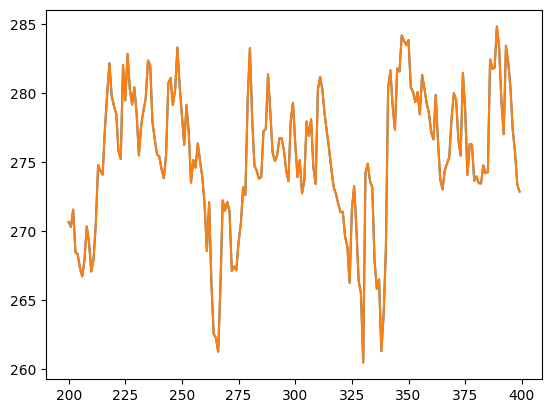

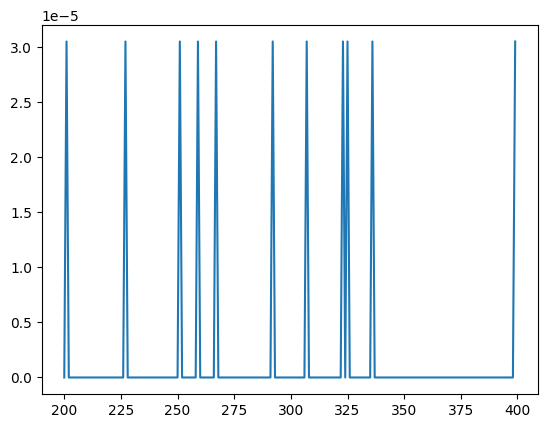

In [11]:
import matplotlib.pyplot as plt

time = list(range(step6_using_isimip_obs_future.size))
plt.plot(time[200:400], step6_using_isimip_obs_future[200:400])
plt.plot(time[200:400], isimip_mapping[200:400])
plt.show()
plt.plot(time[200:400], step6_using_isimip_obs_future[200:400]-isimip_mapping[200:400])
plt.show()

At least for tas ISIMIP and mine results are in agreement. TODO: check other options. Only thing that influences the results is n_quantiles determining the size of the ISIMIP-grid for computing quantiles. If it is smaller then deviations get larger

# Step5 & 6

In [69]:
from PACKAGE_NAME.code_isimip.bias_adjustment import adjust_bias_one_month, map_quantiles_parametric_trend_preserving
import PACKAGE_NAME.code_isimip.utility_functions as uf

obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("tas", grid_point = [1, 1])
debiaser = ISIMIP.from_variable(variable="tas")
#debiaser.event_likelihood_adjustment = False

for chosen_month in range(1, 13):
    obs_month = obs[month(dates["obs"]) == chosen_month]
    cm_hist_month = cm_hist[month(dates["cm_hist"]) == chosen_month]
    cm_future_month = cm_future[month(dates["cm_future"]) == chosen_month]

    obs_future_month = debiaser.step5(obs_month, cm_hist_month, cm_future_month)
    step6_output = debiaser.step6(obs_month, obs_future_month, cm_hist_month, cm_future_month)
    isimip_mapping = map_quantiles_parametric_trend_preserving(
        x_obs_hist = obs_month, x_sim_hist = cm_hist_month, x_sim_fut = cm_future_month, 
        distribution = "normal", 
        trend_preservation = debiaser.trend_preservation_method, 
        adjust_p_values=debiaser.event_likelihood_adjustment,
        lower_bound = None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound,
        lower_threshold = None if np.isinf(debiaser.lower_threshold) else debiaser.lower_threshold,
        upper_bound = None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound,
        upper_threshold = None if np.isinf(debiaser.upper_threshold) else debiaser.upper_threshold,
        unconditional_ccs_transfer = not debiaser.trend_transfer_only_for_values_within_threshold,
        trendless_bound_frequency = False, #???
        n_quantiles = min(obs_month.size, cm_hist_month.size, cm_future_month.size)-1,
        p_value_eps=1e-10,
        max_change_factor=100.0,
        max_adjustment_factor=9.0
    )
    pct = np.sum(np.isclose(step6_output, isimip_mapping))/isimip_mapping.size
    max_deviation = np.max(np.abs(step6_output-isimip_mapping))
    print("Month: %s, Percentage agreement: %s, Max deviation: %s"%(chosen_month, pct, max_deviation))





Month: 1, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 2, Percentage agreement: 0.9931102362204725, Max deviation: 0.003692627
Month: 3, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 4, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 5, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 6, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 7, Percentage agreement: 1.0, Max deviation: 6.1035156e-05
Month: 8, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 9, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 10, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 11, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 12, Percentage agreement: 1.0, Max deviation: 3.0517578e-05


# Step 4, 5 and 6

In [67]:
from PACKAGE_NAME.code_isimip.bias_adjustment import adjust_bias_one_month

obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("tas", grid_point = [1,1])
debiaser = ISIMIP.from_variable(variable="tas")

for chosen_month in range(1, 13):
    obs_month = obs[month(dates["obs"]) == chosen_month]
    cm_hist_month = cm_hist[month(dates["cm_hist"]) == chosen_month]
    cm_future_month = cm_future[month(dates["cm_future"]) == chosen_month]
    
    years_obs_hist = year(dates["obs"][month(dates["obs"]) == chosen_month])
    years_cm_hist = year(dates["cm_hist"][month(dates["cm_hist"]) == chosen_month])
    years_cm_future = year(dates["cm_future"][month(dates["cm_future"]) == chosen_month])
    
    results = debiaser._apply_on_window(obs_month, cm_hist_month, cm_future_month, years_obs_hist, years_cm_hist, years_cm_future)

    isimip_results = adjust_bias_one_month(
        data = {'obs_hist': [obs_month], 'sim_hist': [cm_hist_month], 'sim_fut': [cm_future_month]},
        years = {'obs_hist': years_obs_hist, 'sim_hist': years_cm_hist, 'sim_fut': years_cm_future},
        long_term_mean = {'obs_hist' : [obs_month.mean()], 'sim_hist' : [cm_hist_month.mean()], 'sim_fut' : [cm_future_month.mean()]},
        lower_bound = [None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound],
        lower_threshold = [None if np.isinf(debiaser.lower_threshold) else debiaser.lower_threshold],
        upper_bound = [None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound],
        upper_threshold = [None if np.isinf(debiaser.upper_threshold) else debiaser.upper_threshold],
        unconditional_ccs_transfer=[not debiaser.trend_transfer_only_for_values_within_threshold],
        trendless_bound_frequency=[False],
        randomization_seed=None,
        detrend=[debiaser.detrending],
        rotation_matrices=[],
        n_quantiles=min(obs_month.size, cm_hist_month.size, cm_future_month.size)-1,
        distribution=["normal"],
        trend_preservation=[debiaser.trend_preservation_method],
        adjust_p_values=[debiaser.event_likelihood_adjustment],
        invalid_value_warnings=True
    )[0]
    
    pct = np.sum(np.isclose(results, isimip_results))/results.size
    max_deviation = np.max(np.abs(results-isimip_results))
    print("Month: %s, Percentage agreement: %s, Max deviation: %s"%(chosen_month, pct, max_deviation))


Month: 1, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 2, Percentage agreement: 0.9980314960629921, Max deviation: 0.002960205
Month: 3, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 4, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 5, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 6, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 7, Percentage agreement: 1.0, Max deviation: 6.1035156e-05
Month: 8, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 9, Percentage agreement: 1.0, Max deviation: 6.1035156e-05
Month: 10, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 11, Percentage agreement: 1.0, Max deviation: 3.0517578e-05
Month: 12, Percentage agreement: 1.0, Max deviation: 3.0517578e-05


In [56]:
from PACKAGE_NAME.code_isimip.utility_functions import subtract_or_add_trend
# Step 3
chosen_month = 2

obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("tas", grid_point = [1,1])
debiaser = ISIMIP.from_variable(variable="tas")
debiaser.detrending = True

obs_month = obs[month(dates["obs"]) == chosen_month]
cm_hist_month = cm_hist[month(dates["cm_hist"]) == chosen_month]
cm_future_month = cm_future[month(dates["cm_future"]) == chosen_month]

years_obs_hist = year(dates["obs"][month(dates["obs"]) == chosen_month])
years_cm_hist = year(dates["cm_hist"][month(dates["cm_hist"]) == chosen_month])
years_cm_future = year(dates["cm_future"][month(dates["cm_future"]) == chosen_month])

    
# detrend:
obs_hist_detrended, _ = debiaser._step3_remove_trend(obs_month, years_obs_hist)
cm_hist_detrended, _ = debiaser._step3_remove_trend(cm_hist_month, years_cm_hist)
cm_future_detrended, trend_cm_future = debiaser._step3_remove_trend(cm_future_month, years_cm_future)


obs_hist_detrended_isimip, t1 = uf.subtract_or_add_trend(obs_month, years_obs_hist)
cm_hist_detrended_isimip, t2 = uf.subtract_or_add_trend(cm_hist_month, years_cm_hist)
cm_future_detrended_isimip, t3 = uf.subtract_or_add_trend(cm_future_month, years_cm_future)


In [58]:
all(cm_future_detrended-cm_future_detrended_isimip == 0)

True

With high nnumber of quantiles isimip is consistent